# Notebook to go step by step in the selection/reduction/calibration of DL0 data to DL1
<font size="4">
**Content:**
- Data loading
- Calibration:
    - Pedestal substraction
    - Peak integration
    - Conversion of digital counts to photoelectrons.
    - High gain/low gain combination
- Cleaning
- Hillas parameters
- Disp reconstruction (from Hillas pars)
- TEST: High gain/Low gain 
- Using of Pyhessio to access more MC information:
    - Simulated phe, number of simulated events, simulated energy range, etc.
    - Calculation of the spectral weight for one event.
- TEST: Comparison of Hillas intensity with simulated number of phe.
- Spectral weighting for a set of events.

### Some imports...

In [1]:
from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.io.eventseeker import EventSeeker
import astropy.units as u
from copy import deepcopy

from lstchain.calib import lst_calibration
from ctapipe.image import hillas_parameters

import pyhessio
from eventio.simtel.simtelfile import SimTelFile

import lstchain.reco.utils as utils
from lstchain.reco import dl0_to_dl1
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

## Data loading

Get the origin file with dl0 data which is a simtelarray file

In [2]:
#input_filename=get_dataset_path('gamma_test_large.simtel.gz')
input_filename="/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run8___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

Get the data events into a ctapipe event container. We are only interested in LST1 events

In [3]:
tel_id = 1
allowed_tels = {tel_id}
source = event_source(input_filename)
source.allowed_tels = allowed_tels

In [4]:
## Load the first event
event = next(iter(source))


## OR select an event manually
#seeker = EventSeeker(source)
#event = seeker[4]

# OR Find an event that saturates the high gain waveform
'''
counter = 0
howmany = 4
for event in source:
        if np.any(event.r0.tel[1].waveform > 4094):
            bright_event = deepcopy(event)
            tel_id = tel_id
            counter = counter + 1
            if counter > howmany:
                break
event = bright_event
'''
## OR find a bright LST event:
# intensity = 0
# for event in source:
#     for tid in event.r0.tels_with_data:
#         if event.r0.tel[tid].image.sum() > intensity and tid in np.arange(8):
#             intensity = event.r0.tel[tid].image.sum()
#             bright_event = deepcopy(event)
#             tel_id = tid
# event = bright_event

'\ncounter = 0\nhowmany = 4\nfor event in source:\n        if np.any(event.r0.tel[1].waveform > 4094):\n            bright_event = deepcopy(event)\n            tel_id = tel_id\n            counter = counter + 1\n            if counter > howmany:\n                break\nevent = bright_event\n'

Take a look at the event container. Select any event using the event seeker

In [5]:
event.r0.tel[1]

ctapipe.io.containers.R0CameraContainer:
                  trigger_time: Telescope trigger time, start of waveform
                                readout, None for MCs
                  trigger_type: camera's event trigger type if applicable
                  num_trig_pix: Number of trigger groups (sectors) listed
                   trig_pix_id: pixels involved in the camera trigger
                         image: numpy array containing integrated ADC data
                                (n_channels x n_pixels) DEPRECATED
                      waveform: numpy array containing ADC samples(n_channels x
                                n_pixels, n_samples)
                   num_samples: number of time samples for telescope

In [6]:
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

In [7]:
EvID = event.r0.event_id
print(EvID)

1400


Get the waveform data

In [8]:
data = event.r0.tel[tel_id].waveform
data.shape

(2, 1855, 30)

The waveform is a matrix, has 30 samples in each of the 1855 pixels, for 2 gains. 

### We can plot the waveforms and have an idea of their shapes.

Lame loop to find a pixel with signal: 

In [9]:
maxvalue=0
for pixel in enumerate(data[0]):
    maxsample = max(pixel[1])
    if maxsample > maxvalue:
        maxvalue = maxsample
        pixelwithsignal = pixel[0]

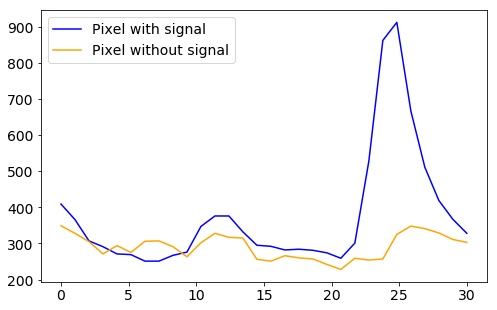

In [10]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14
nsamples = data.shape[2]
sample = np.linspace(0,30,nsamples)
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color =  "blue")
plt.plot(sample,data[0][0],label="Pixel without signal", color = "orange")
plt.legend()

## Calibration

**Get the pedestal, which is is the average (for pedestal events) of the *sum* of all samples, from sim_telarray**

In [11]:
ped = event.mc.tel[tel_id].pedestal
ped.shape

(2, 1855)

Each pixel has its pedestal for the two gains.

**Correct the pedestal (np.atleast_3d function converts 2D to 3D matrix)**

In [12]:
pedcorrectedsamples = data - np.atleast_3d(ped) / nsamples
pedcorrectedsamples.shape

(2, 1855, 30)

**We can now compare the corrected waveforms with the previous ones**

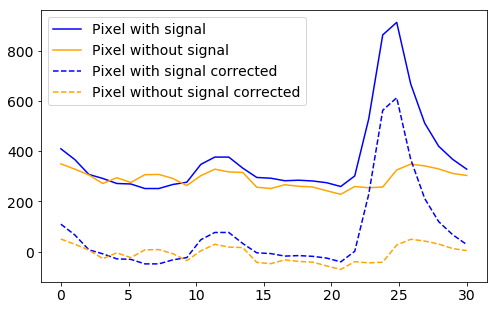

In [13]:
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color="blue")
plt.plot(sample,data[0][0],label="Pixel without signal",color="orange")
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal corrected",color="blue",linestyle="--")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal corrected",color="orange",linestyle="--")
plt.legend()

## Integration

**We must now find the peak in the waveform and do the integration to extract the charge in the pixel**

In [14]:
from ctapipe.image.charge_extractors import LocalPeakIntegrator

In [15]:
integrator = LocalPeakIntegrator(None, None)                                                                                                        
integration, peakpos, window = integrator.extract_charge(pedcorrectedsamples)

In [16]:
integration.shape, peakpos.shape, window.shape

((2, 1855), (2, 1855), (2, 1855, 30))

Integration gives the value of the charge

In [17]:
integration[0][0],integration[0][pixelwithsignal]

(35.471893, 2101.2732)

Peakpos gives the position of the peak (in which sample it falls)

In [18]:
peakpos[0][0],peakpos[0][pixelwithsignal]

(0, 24)

window gives the number of samples used for the integration

In [19]:
window[0][0],window[0][pixelwithsignal]
sample[window[0][0]]

array([0.        , 1.03448276, 2.06896552, 3.10344828, 4.13793103,
       5.17241379, 6.20689655])

**We can plot these positions on top of the waveform and decide if the integration and peak identification has been correct**

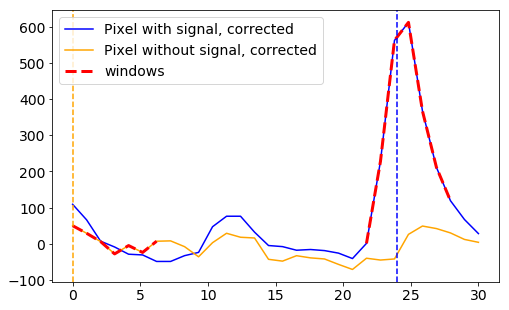

In [20]:
import matplotlib.patches as patches
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal, corrected",color="blue")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal, corrected",color="orange")
plt.plot(sample[window[0][0]],pedcorrectedsamples[0][0][window[0][0]],
         color="red",label="windows",linewidth=3,linestyle="--")
plt.plot(sample[window[0][pixelwithsignal]],pedcorrectedsamples[0][pixelwithsignal][window[0][pixelwithsignal]],
         color="red",linewidth=3,linestyle="--")
plt.axvline(peakpos[0][0],linestyle="--",color="orange")
plt.axvline(peakpos[0][pixelwithsignal],linestyle="--",color="blue")
plt.legend()

**Finally we must convert the charge from digital counts to photoelectrons multipying by the correlation factor**

In [21]:
signals = integration.astype(float) 
dc2pe = event.mc.tel[tel_id].dc_to_pe  # numgains * numpixels
signals *= dc2pe

**Choose the correct calibration factor for each pixel depending on its intensity. Very bright pixels saturates and the local peak integrator underestimates the intensity of the pixel.**

In [22]:
data[0]
combined = signals[0].copy() # On a basis we will use the high gain
for pixel in range(0,combined.size):
    if np.any(data[0][pixel] > 4094):
        print(signals[1][pixel],signals[0][pixel])
        combined[pixel] = signals[1][pixel]


**And fill the DL1 containers**

In [23]:
event.dl1.tel[tel_id].image = combined                                                                                                       
event.dl1.tel[tel_id].peakpos = peakpos
event.dl1.tel[tel_id]

ctapipe.io.containers.DL1CameraContainer:
                         image: np array of camera image, after waveform
                                integration (N_pix)
                  gain_channel: boolean numpy array of which gain channel was
                                used for each pixel in the image
             extracted_samples: numpy array of bools indicating which samples
                                were included in the charge extraction as a
                                result of the charge extractor chosen.
                                Shape=(nchan, npix, nsamples).
                       peakpos: numpy array containing position of the peak as
                                determined by the peak-finding algorithm for
                                each pixel
                       cleaned: numpy array containing the waveform after
                                cleaning

**Say hello to our shower!**

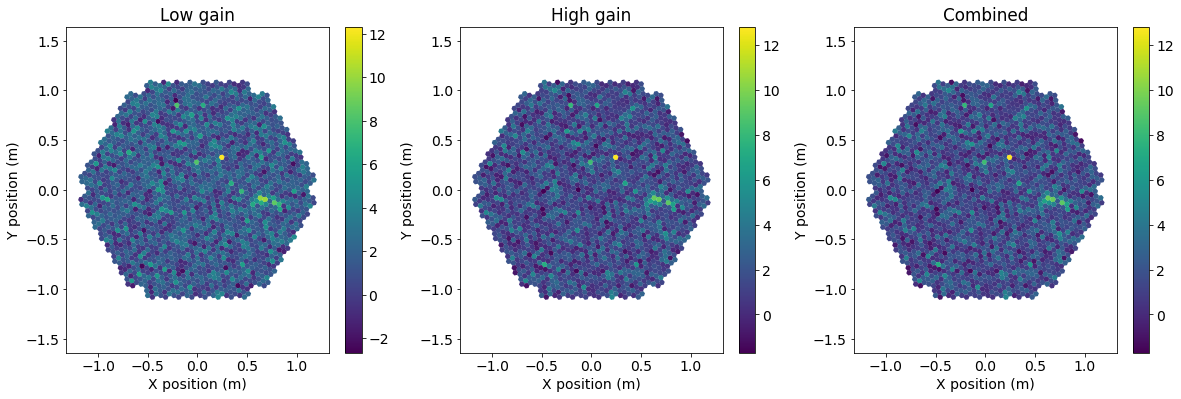

In [24]:
from ctapipe.visualization import CameraDisplay
camera = event.inst.subarray.tel[tel_id].camera
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14
plt.subplot(1,3,1)
display = CameraDisplay(camera,title="Low gain")
display.add_colorbar()
display.image = signals[1]
plt.subplot(1,3,2)
display = CameraDisplay(camera,title = "High gain")
display.add_colorbar()
display.image = signals[0]
plt.subplot(1,3,3)
display = CameraDisplay(camera,title = "Combined")
display.add_colorbar()
display.image = combined

## Image cleaning

In [25]:
from ctapipe.image import hillas_parameters, tailcuts_clean
cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 3,                                                                                                            
                       'picture_thresh': 6,                                                                                                             
                       'keep_isolated_pixels': False,                                                                                                   
                       'min_number_picture_neighbors': 1                                                                                                
                       }

In [26]:
signal = combined
signal_pixels = cleaning_method(camera,signal,**cleaning_parameters)

We use the combined image.

In [27]:
image = signal                                                                                                                          
image[~signal_pixels] = 0

**Let's take a look at the clean and shiny image**

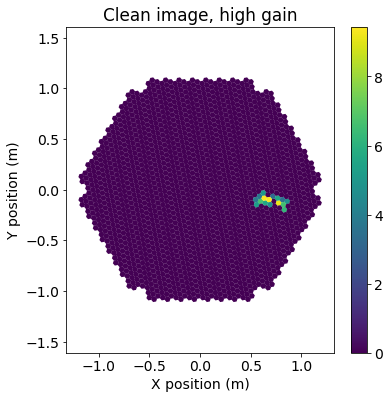

In [28]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
display = CameraDisplay(camera,title = "Clean image, high gain")
display.image = image
display.add_colorbar()

## Hillas parameters

First compute them:

In [29]:
hillas = hillas_parameters(camera, image)
hillas.intensity

92.7431159449425

**And plot them over the image**

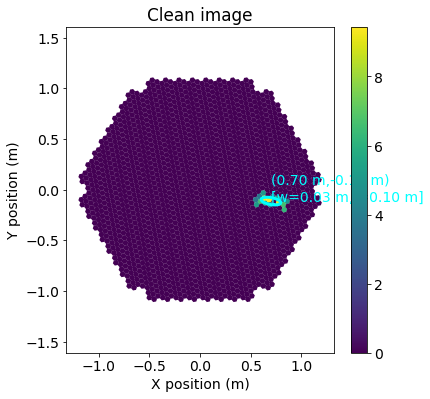

In [30]:
display = CameraDisplay(camera,title = "Clean image")
display.add_colorbar()
display.image = image
display.overlay_moments(hillas, color='cyan', linewidth=3)

**Also we can calculate the timing parameters**

In [31]:
from ctapipe.image import timing_parameters as time
timepars = time.timing_parameters(camera, image, peakpos[0], hillas)
timepars

ctapipe.io.containers.TimingParametersContainer:
                         slope: Slope of arrival times along main shower axis
                     intercept: intercept of arrival times along main shower
                                axis

In [32]:
timepars.slope,timepars.intercept

(<Quantity -22.78065462 1 / m>, 10.438068578766865)

## Reconstruction of disp

In [33]:
from lstchain.reco.utils import get_event_pos_in_camera, disp_parameters, disp_to_pos

In [34]:
tel = event.inst.subarray.tel[tel_id]

In [35]:
src_pos = get_event_pos_in_camera(event, tel)
disp = disp_parameters(hillas, src_pos[0], src_pos[1])

d = disp.norm
s = disp.sign
dx = disp.dx
dy = disp.dy

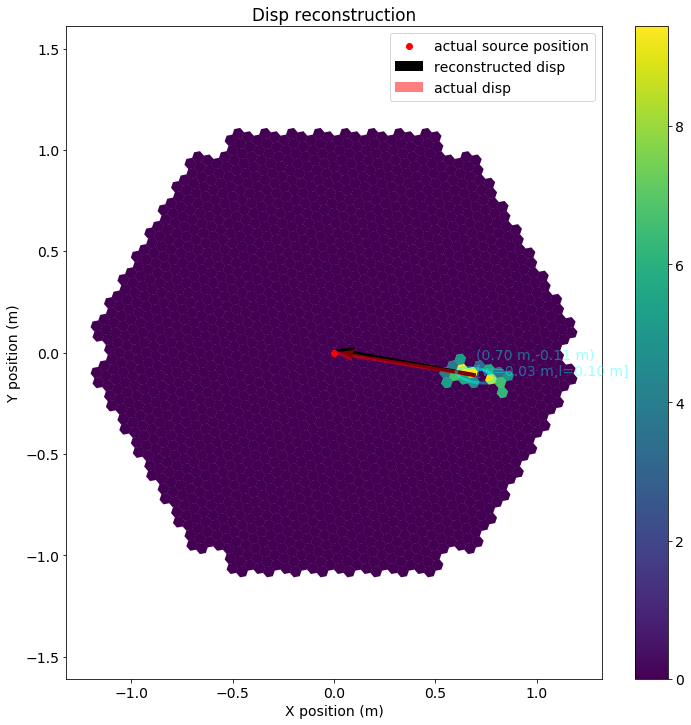

In [36]:
plt.figure(figsize=(12,12))
display = CameraDisplay(camera,title = "Disp reconstruction")
display.add_colorbar()
display.image = image
display.overlay_moments(hillas, color='cyan', linewidth=3, alpha=0.4)
plt.scatter(src_pos[0], src_pos[1], color='red', label='actual source position')
uu = s * d.value * np.cos(hillas.psi)
vv = s * d.value * np.sin(hillas.psi)
plt.quiver(hillas.x, hillas.y, uu, vv, units='xy', scale=1,
           label= "reconstructed disp",
          )

plt.quiver(hillas.x, hillas.y, dx.value, dy.value, 
           units='xy', scale=1,
           color='red',
           alpha=0.5,
           label= "actual disp", 
          )

plt.legend();

**In a real use case, the _disp_ value (length of the vector) is reconstructed by training a random forest.   
The _reconstructed disp_ above assumes a perfect length reconstruction.   
The direction of the `disp` vector is given by the ellipse direction (`hillas.psi`)**

## Lets compare the difference between high and low gain images for all events in the simtelarray file:

In [37]:
intensity_high = np.array([])
intensity_low = np.array([])
nevents = 0
source.max_events=100
for event in source:
    if nevents%100==0:
        print(nevents)
    if nevents >= 500:
        break
    #if np.any(event.r0.tel[1].waveform > 4094):
    #    continue
    geom = event.inst.subarray.tel[tel_id].camera
    lst_calibration(event,tel_id)
    for Nphe_high, Nphe_low in zip(event.dl1.tel[tel_id].image[0],event.dl1.tel[tel_id].image[1]):
        if Nphe_high > 0 and Nphe_low > 0:
            intensity_high = np.append(Nphe_high,intensity_high)
            intensity_low = np.append(Nphe_low,intensity_low)
    nevents=nevents+1

0


0.002737918698196365 0.05924274596029823
0.00019197074351815188 0.03469594348185504
0.07681913635915248 0.08606850542673336
0.48390838263108343 0.22574610451790328


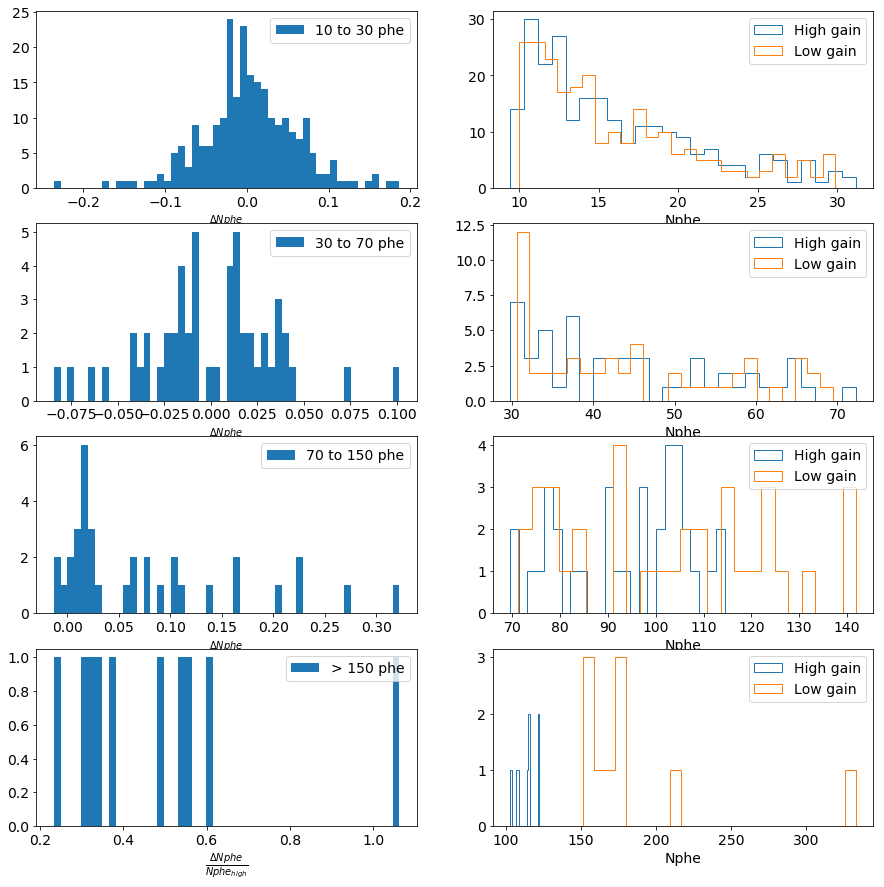

In [38]:
from scipy.stats import norm
plt.figure(figsize=(15,15))
#diff = (np.log10(intensity_low)-np.log10(intensity_high))*np.log(10)
pixels_df = pd.DataFrame(data ={'high_gain':intensity_high,
                                'low_gain':intensity_low,
                                'diff':np.log(intensity_low/intensity_high)})

pixels_df['Bin1'] = (pixels_df['low_gain'] >= 10) & (pixels_df['low_gain'] < 30) 
pixels_df['Bin2'] = (pixels_df['low_gain'] >= 30) & (pixels_df['low_gain'] < 70) 
pixels_df['Bin3'] = (pixels_df['low_gain'] >= 70) & (pixels_df['low_gain'] < 150)
pixels_df['Bin4'] = (pixels_df['low_gain'] >= 150)

plt.subplot(421)
h = plt.hist(pixels_df[pixels_df['Bin1']]['diff'],bins=50,label='10 to 30 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(422)
h2 = plt.hist(pixels_df[pixels_df['Bin1']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin1']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin1']]['diff'])
print(mu,sigma)
plt.subplot(423)
h = plt.hist(pixels_df[pixels_df['Bin2']]['diff'],bins=50,label='30 to 70 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(424)
h2 = plt.hist(pixels_df[pixels_df['Bin2']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin2']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin2']]['diff'])
print(mu,sigma)
plt.subplot(425)
h = plt.hist(pixels_df[pixels_df['Bin3']]['diff'],bins=50,label='70 to 150 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(426)
h2 = plt.hist(pixels_df[pixels_df['Bin3']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin3']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin3']]['diff'])
print(mu,sigma)
plt.subplot(427)
h = plt.hist(pixels_df[pixels_df['Bin4']]['diff'],bins=50,label='> 150 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(428)
h2 = plt.hist(pixels_df[pixels_df['Bin4']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin4']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin4']]['diff'])
print(mu,sigma)

## Use Eventio to access to extra MC data

In [39]:
src_eventio = SimTelFile(input_filename)
emin, emax = src_eventio.mc_run_headers[0]['E_range']*1e3 #GeV
spectral_index = src_eventio.mc_run_headers[0]['spectral_index']
num_showers = src_eventio.mc_run_headers[0]['num_showers']
num_use = src_eventio.mc_run_headers[0]['num_use']
Simulated_Events = num_showers * num_use
Max_impact = src_eventio.mc_run_headers[0]['core_range'][1]*1e2 #cm
Area_sim = math.pi * math.pow(Max_impact,2)
cone = src_eventio.mc_run_headers[0]['viewcone'][1]

In [40]:
from eventio import EventIOFile
from eventio.simtel import CameraSettings
from eventio.iact import PhotoElectrons, TelescopeData
from eventio.search_utils import yield_n_subobjects

## Calculate the spectral weighting for the event

In [41]:
emin,emax,spectral_index,cone,Max_impact

(3.0, 330000.0, -2.0, 0.0, 160000.0)

In [42]:
particle = utils.guess_type(input_filename)
K = Simulated_Events*(1+spectral_index)/(emax**(1+spectral_index)-emin**(1+spectral_index))                    
A = np.pi*Max_impact**2
Omega = 2*np.pi*(1-np.cos(cone))
if cone==0:
    Omega=1
MeVtoGeV = 1e-3                                                     
if particle=="gamma":                                                
    K_w = 5.7e-16*MeVtoGeV                                           
    index_w = -2.48                                                  
    E0 = 0.3e6*MeVtoGeV                                              
                                                                         
if particle=="proton":                                               
    K_w = 9.6e-2                                                     
    index_w = -2.7                                                   
    E0 = 1                                                           
                                                                         
Simu_E0 = K*E0**spectral_index                                                
N_ = Simu_E0*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)                                                                 
R = K_w*A*Omega*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)

energy = event.mc.energy.value

w = ((energy/E0)**(index_w-spectral_index))*R/N_

print('Spectral weight: ',w)

Spectral weight:  7.890102516635426e-08


## We can compare the Hillas intensity with the MC photoelectron size of the events to check the effects of cleaning

**Set the number of events that we want to analyze and the name of the output h5 file(None for using all events in the file)**

In [55]:
dl0_to_dl1.max_events = 300                      
output_filename = 'dl1_' + os.path.basename(input_filename).split('.')[0] + '.h5'

**Run lstchain to get dl1 events**

In [56]:
dl0_to_dl1.r0_to_dl1(input_filename,output_filename)

0
100


In [62]:
df_dl1 = pd.read_hdf(output_filename, key='events/LSTCam')
nevents = df_dl1.shape[0]

**Use Pyeventio to obtain the number of MC photoelectrons in the camera**

In [64]:
mc_phe = np.array([])
event_ids = np.array([])
i = 0
with SimTelFile(input_filename) as f:
    for event in f.iter_array_events():
        for tel in event['telescope_events']:
            if tel==1:
                event_id = event['event_id']
                nphe = event['photoelectron_sums']['num_pe'][0]
                mc_phe = np.append(mc_phe, nphe)
                event_ids = np.append(event_ids, event_id)
                if i%100==0: 
                    print(i)
                i+=1
            #print(event['photoelectron_sums'])
        if i>=nevents:
            break

0
100


**Use pandas to assign the info obtained with eventio to the corresponding dl1 previous events**

In [65]:
mc_df = pd.DataFrame()    
mc_df['mc_phe'] = mc_phe
mc_df['event_id'] = event_ids.astype(int)

df_dl1 = df_dl1.set_index('event_id')
mc_df = mc_df.set_index('event_id').reindex(df_dl1.index)
df_dl1['mc_phe'] = np.log10(mc_df['mc_phe'])

**Plot the hillas intensity vs mc photoelectron size**

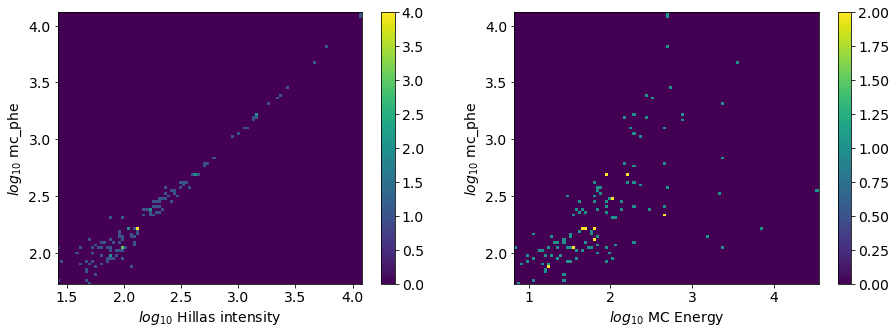

In [66]:
plt.figure(figsize=(15,5))
plt.subplot(121)
h = plt.hist2d(df_dl1[df_dl1['mc_phe']>0]['intensity'],df_dl1[df_dl1['mc_phe']>0]['mc_phe'],bins=100)
plt.xlabel('$log_{10}$ Hillas intensity')
plt.ylabel('$log_{10}$ mc_phe')
plt.colorbar(h[3])
plt.subplot(122)
h = plt.hist2d(df_dl1[df_dl1['mc_phe']>0]['mc_energy'],df_dl1[df_dl1['mc_phe']>0]['mc_phe'],bins=100)
plt.xlabel('$log_{10}$ MC Energy')
plt.ylabel('$log_{10}$ mc_phe')
plt.colorbar(h[3])

## Apply the spectral weighting for this set of events

In [67]:
df_dl1['w'] = ((10**df_dl1['mc_energy']/E0)**(index_w-spectral_index))*R/N_

Text(0.5, 0, '$log_{10}E (GeV)$')

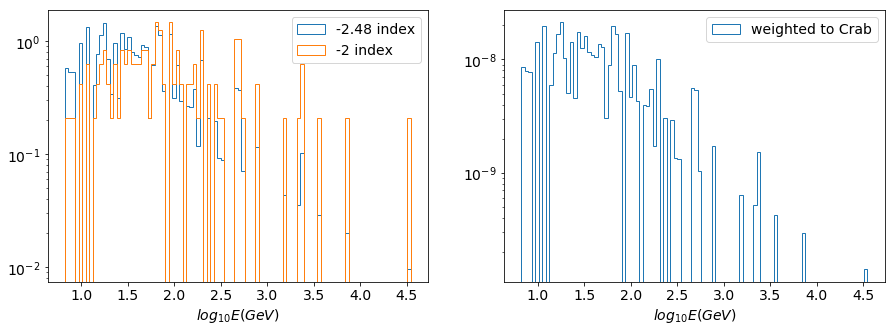

In [68]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,weights = df_dl1['w'],density=1,label="-2.48 index")
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,density=1,label="-2 index")
plt.yscale('log')
plt.xlabel("$log_{10}E (GeV)$")
plt.legend()
plt.subplot(122)
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,weights = df_dl1['w'],label="weighted to Crab")
plt.legend()
plt.yscale('log')
plt.xlabel("$log_{10}E (GeV)$")
#plt.xscale('log')